## Import the libraries

In [1]:
import PIL
import geopandas as gpd
import shapely
import rasterio
import numpy as np
import scipy as sp
import cv2 as cv2
import skimage as sk
import matplotlib.pyplot as plt
import itertools
import pickle
from matplotlib.colors import LinearSegmentedColormap
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from gstools import SRF, Gaussian

## LGCP results
we will make a figure that shows the layers of a LGCP, namely the gaussian random field, the mean density and the point pattern. The figure will showe realizations of the process at different correlation lengths 

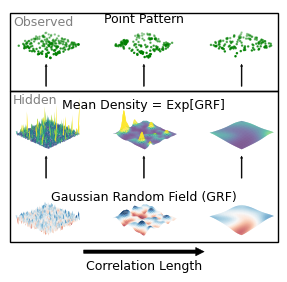

In [11]:

N_elements = 100
x = y = range(N_elements)


def get_field(rho,var): 

    x = y = range(N_elements)

    model = Gaussian(dim=2, var=var, len_scale=rho)
    srf = SRF(model, seed=201724109)

    field = srf.structured([x, y])

    return field


def nhpp(density_matrix):
    
    # Region dimensions (can be scaled to any size)
    height, width = density_matrix.shape
    scale = 1  # scale factors for plotting
    
    # Initialize list to hold point coordinates
    points = []
    
    # Generate points
    for i in range(height):
        for j in range(width):
            # Number of points in this pixel
            num_points = np.random.poisson(density_matrix[i, j])
            # Generate each point
            for _ in range(num_points):
                # Points are uniformly distributed within the pixel
                x = np.random.uniform(j, j+1, 1) * scale
                y = np.random.uniform(i, i+1, 1) * scale
                points.append((x, y))
    
    # Unzip points for plotting
    points_x, points_y = zip(*points)
    return points_x, points_y
x_mesh, y_mesh = np.meshgrid(x, y)

#fig, main_ax = plt.subplots(figsize=(17/2.54,10/ 2.54))        

fig, axs = plt.subplots(3, 3,figsize=(8/2.54,7/2.54),subplot_kw=dict(projection='3d'))

colors = [(0, 0, 0), (0, 1, 0)]  # Black to green
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'my_black_green'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

rhos = [1, 10, 40] 
var = 1
fields = [ get_field(rho,var) for rho in rhos]
expfields = [np.exp(field) for field in fields]


elev = 25
azim = 45

for i in range(3):

    rho = rhos[i]
    xp, yp = nhpp(expfields[i]/100)

    axs[0,i].scatter( xp, yp, zs=0, zdir='z', color='green',s = 0.6)  # Plot on the x-y plane at z=0
    axs[0,i].view_init(elev=elev, azim=azim)  # elevation and azimuth
    axs[0,i].set_box_aspect([1,1,0.1])  # Adjusts the aspect ratio to be equal in all dimensions
    axs[0,i].axis('off')

    surf = axs[1,i].plot_surface(x_mesh, y_mesh, expfields[i], cmap="viridis", vmin=0, vmax=5)     
    axs[1,i].set_zlim(0, 10)  # Set the z-axis limits
    axs[1,i].view_init(elev=elev, azim=azim)  # elevation and azimuth
    axs[1,i].set_box_aspect([1,1,0.15])  # Adjusts the aspect ratio to be equal in all dimensions
    axs[1,i].axis('off')
    
    surf = axs[2,i].plot_surface(x_mesh, y_mesh, fields[i], cmap='RdBu', vmin=-2, vmax=2)    
    axs[2,i].set_zlim(-2, 2)  # Set the z-axis limits
    axs[2,i].view_init(elev=elev, azim=azim)  # elevation and azimuth
    axs[2,i].set_box_aspect([1,1,0.15])  # Adjusts the aspect ratio to be equal in all dimensions
    axs[2,i].axis('off')


y_pad = 0.01

arrow_length = 1/9

fig.text(0.5, 1/3 - arrow_length/2+y_pad, s = "Gaussian Random Field (GRF)",
            fontsize=9, va='top', ha='center')

fig.text(0.5, 2/3- arrow_length/2 + y_pad, s = "Mean Density = Exp[GRF]",
            fontsize=9, va='top', ha='center')

fig.text(0.5, 1- arrow_length/2 + y_pad - 0.02, s = "Point Pattern",
            fontsize=9, va='top', ha='center')

hidden_box_height = 2/3 - 1/6 + 0.05
hidden_box_y_offset =  1/10

width_margin = 0.15

rect = patches.Rectangle((width_margin/2, 1/10), 1-width_margin,hidden_box_height, linewidth=1, edgecolor='black', transform=fig.transFigure, facecolor='none',zorder = 100)
fig.patches.append(rect)


observed_box_height = 1/3 - 0.05
rect = patches.Rectangle((width_margin/2, hidden_box_height+hidden_box_y_offset), 1-width_margin, observed_box_height, linewidth=1, edgecolor='black', transform=fig.transFigure, facecolor='none',zorder = 100)

fig.patches.append(rect)


arrow_length = 1/10

y_shift = 1/25


x_positions = [0.5 - 1/3 +0.023,0.5,0.5 + 1/3 - 0.023]
for j in range(2):
    for i in range(3):
        
        y_pos = (j+1)*1/3 + y_shift
        x_pos = x_positions[i]
        arrow = FancyArrowPatch(( x_pos, y_pos - arrow_length/2), (x_pos, y_pos+ arrow_length/2),
                                transform=fig.transFigure,
                                 mutation_scale=3, color='black', lw=0.4)
        fig.patches.append(arrow)



layer_pad = 0.01
fig.text(width_margin/2+layer_pad,  hidden_box_height+hidden_box_y_offset - layer_pad, s = "Hidden",
            fontsize=9, va='top', ha='left',color = "Grey")



fig.text(width_margin/2+layer_pad,observed_box_height + hidden_box_height+hidden_box_y_offset - layer_pad, s = "Observed",
            fontsize=9, va='top', ha='left',color = "Grey")


arrow = FancyArrowPatch(( 0.3, 1/15),  (0.7, 1/15),
                                transform=fig.transFigure,
                                 mutation_scale=12, color='black', lw=0.4)

fig.patches.append(arrow)


fig.text(0.5 ,1/15*0.6, s = "Correlation Length",
            fontsize=9, va='top', ha='center')


plt.tight_layout()  # Adjust layout
#plt.show()
plt.savefig("../figures/LGCP.svg",bbox_inches='tight', pad_inches=0)
#plt.savefig("../figures/LGCP.png",bbox_inches='tight', pad_inches=0)

## Data

here we will make a figure showing the raw images that where used in the analysis along with, some of the constructed covariates

| nucleus channel|  mt channel| er channel |

|peroxisome channel  | distance map   |  mt contact |
___ the whole data set __
mixed of all 


In [3]:
# Load the pickle data
with open("../data/processed/pickled_dataset.pkl" , 'rb') as file:
    pickled_data = pickle.load(file)

In [5]:
mt_img = (255*pickled_data["cell3"]["raw"]["mitochondria"]/np.max(pickled_data["cell3"]["raw"]["mitochondria"])).astype(np.uint8)

In [7]:
mt_img.dtype

dtype('uint8')

In [9]:
scale = pickled_data["scale"]

In [11]:

def imshow(ax,image):
    xlength = image.shape[1]/scale
    ylength = image.shape[0]/scale
    ax.imshow(image, cmap='binary',origin = "lower",extent = (0,xlength,0,ylength))
    ax.set_xticks([])
    ax.set_yticks([])


def combine_colorized_images_white_bg(images, colors, weights=None):
    """
    Combines a list of grayscale images with specified colors into a single colored image on a white background,
    allowing for weighted importance of each image.

    Parameters:
    images (list of 2D numpy arrays): List of grayscale images.
    colors (list of tuples): List of RGB tuples (values between 0 and 1) for each image.
    weights (list of floats, optional): List of weights to adjust the importance of each image.

    Returns:
    combined_image (numpy array): The combined RGB image on a white background.
    """
    if len(images) != len(colors):
        raise ValueError("The number of images must match the number of colors.")
    
    num_images = len(images)

    if weights is None:
        weights = [1.0] * num_images  # Equal importance by default
    elif len(weights) != num_images:
        raise ValueError("The number of weights must match the number of images.")

    # Normalize weights so that their sum equals the number of images
    total_weight = sum(weights)
    normalized_weights = [w / total_weight * num_images for w in weights]

    # Ensure all images are numpy arrays and normalize them
    normalized_images = []
    for img in images:
        img = np.array(img, dtype=np.float32)
        max_val = img.max()
        img /= max_val if max_val != 0 else 1  # Normalize to [0, 1]
        normalized_images.append(img)

    # Initialize the combined image with a white background
    height, width = normalized_images[0].shape
    combined_image = np.ones((height, width, 3), dtype=np.float32)  # White background

    # Overlay each colorized image onto the combined image with weights
    for img, color, weight in zip(normalized_images, colors, normalized_weights):
        # Validate color
        if len(color) != 3:
            raise ValueError("Each color must be a tuple with three components (R, G, B).")
        if any(c < 0 or c > 1 for c in color):
            raise ValueError("Color components must be between 0 and 1.")

        # Create the colorized image
        colorized_img = np.stack([img * c for c in color], axis=-1)

        # Create an alpha mask and apply the weight
        alpha = np.expand_dims(img * weight, axis=-1)  # Adjust alpha by weight

        # Clip alpha values to [0, 1]
        alpha = np.clip(alpha, 0, 1)

        # Composite the colorized image onto the combined image
        combined_image = alpha * colorized_img + (1 - alpha) * combined_image

    # Clip combined image values to [0, 1]
    combined_image = np.clip(combined_image, 0, 1)

    return combined_image



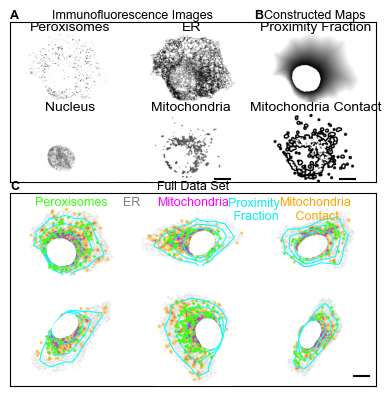

In [13]:
from skimage import exposure


fig, main_ax = plt.subplots(figsize=(12/2.54,12/ 2.54))       

main_ax.axis('off')


single_cell_ax_height = 0.47
Y_pad = 0.03

single_cell_ax = main_ax.inset_axes([0, 1- single_cell_ax_height + Y_pad,1, single_cell_ax_height- Y_pad])
single_cell_ax.set_xticks([])
single_cell_ax.set_yticks([])


main_ax.text((2/3)/2, 1, "Immunofluorescence Images", transform=main_ax.transAxes,
            fontsize=9, font ="Arial", va='bottom', ha='center',zorder =100)


main_ax.text(0, 1, "A", transform=main_ax.transAxes,
            fontsize=9, font ="Arial", fontweight='bold', va='bottom', ha='left',zorder =100)

main_ax.text(2/3 +  (1/3)/2, 1, "Constructed Maps", transform=main_ax.transAxes,
            fontsize=9, font ="Arial", va='bottom', ha='center',zorder =100)

main_ax.text(2/3, 1, "B", transform=main_ax.transAxes,
            fontsize=9, font ="Arial", fontweight='bold', va='bottom', ha='left',zorder =100)

hight= 0.43
pad_between_fl_cm = 0.01
image_width = (1- pad_between_fl_cm)/3
fl_data_axes = []

for i in range(2):
    fl_data_axes.append(single_cell_ax.inset_axes([i*image_width,0.5,image_width,hight]))
    fl_data_axes.append(single_cell_ax.inset_axes([i*image_width,0,image_width,hight]))

fl_data_axes.append(single_cell_ax.inset_axes([2*image_width+pad_between_fl_cm,0.5,image_width,hight]))
fl_data_axes.append(single_cell_ax.inset_axes([2*image_width+pad_between_fl_cm,0,image_width,hight]))


titles = ["Peroxisomes","Nucleus","ER","Mitochondria","Proximity Fraction","Mitochondria Contact"]


pr_img =pickled_data["cell3"]["raw"]["peroxisomes"]/np.max(pickled_data["cell3"]["raw"]["peroxisomes"])
pr_img[pr_img <0.14] = 0
pr_img = exposure.adjust_gamma(pr_img,0.4)

mt_img =pickled_data["cell3"]["raw"]["mitochondria"]/np.max(pickled_data["cell3"]["raw"]["mitochondria"])
mt_img[mt_img <0.1] = 0
mt_img = exposure.adjust_gamma(mt_img,0.4)

nc_img = pickled_data["cell3"]["raw"]["nucleus"]/np.max(pickled_data["cell3"]["raw"]["nucleus"])
nc_img[nc_img <0.2] = 0
nc_img = exposure.adjust_gamma(nc_img,0.4)

er_img = pickled_data["cell3"]["raw"]["ER"]/ np.max(pickled_data["cell3"]["raw"]["ER"])
er_img[er_img < 0.2] = 0
er_img = exposure.adjust_gamma(er_img,1)


images = [
    pr_img,
    nc_img,
   er_img,
   mt_img,
    pickled_data["cell3"]["distance"]["fractional distance"],
    pickled_data["cell3"]["proximity"]["mitochondria"],
]

for ax,title,image in zip(fl_data_axes,titles,images):
    ax.set_title(title,pad = 0,fontsize = 9,font ="Arial")
    ax.set_xticks([])
    ax.set_yticks([])
    imshow(ax,image)
    ax.axis("off")


data_set_ax = main_ax.inset_axes([0, 0,1,1-single_cell_ax_height])

main_ax.text(1/2, 1-single_cell_ax_height, "Full Data Set", transform=main_ax.transAxes,
            fontsize=9, font= "Arial",va='bottom', ha='center',zorder =100)

main_ax.text(0, 1-single_cell_ax_height, "C", transform=main_ax.transAxes,
            fontsize=9, font= "Arial",fontweight='bold', va='bottom', ha='left',zorder =100)


data_set_ax.text(1/6,0.98,"Peroxisomes",color = "#39FF14",horizontalalignment = "center",verticalalignment = "top",font= "Arial",fontsize = 9,zorder =100)
data_set_ax.text(2/6,0.98,"ER",color = "grey",horizontalalignment = "center",verticalalignment = "top",font= "Arial",fontsize = 9,zorder =100)
data_set_ax.text(3/6,0.98,"Mitochondria",color = "magenta",horizontalalignment = "center",verticalalignment = "top",font= "Arial",fontsize = 9,zorder =100)
data_set_ax.text(4/6,0.98,"Proximity\n Fraction",color = "#09edecff",horizontalalignment = "center",verticalalignment = "top",font= "Arial",fontsize = 9,zorder =100)
data_set_ax.text(5/6,0.98,"Mitochondria\n Contact",color = "orange",horizontalalignment = "center",verticalalignment = "top",font= "Arial",fontsize = 9,zorder =100)


data_set_ax.set_xticks([])
data_set_ax.set_yticks([])


data_axes = []

cell_list = ["cell6","cell1","cell4","cell3","cell2","cell5"]
for i in range(3):
    for j in range(2):
        data_axes.append(data_set_ax.inset_axes([i/3, j/2,1/3, 1/2]))
        cell = cell_list[j*3 + i]
        width = pickled_data[cell]["raw"]["nucleus"].shape[1]/scale
        height = pickled_data[cell]["raw"]["nucleus"].shape[0]/scale
        pad_y = (65-height)/2
        pad_x = (75-width)/2

        data = pickled_data[cell]

        mt_img =pickled_data[cell]["raw"]["mitochondria"]/np.max(pickled_data[cell]["raw"]["mitochondria"])
        mt_img[mt_img <0.1] = 0
        mt_img = exposure.adjust_gamma(mt_img,0.4)
        
        
        er_img = pickled_data[cell]["raw"]["ER"]/ np.max(pickled_data[cell]["raw"]["ER"])
        er_img[er_img < 0.2] = 0
        er_img = exposure.adjust_gamma(er_img,1)

        
        images = [er_img,mt_img,data["proximity"]["mitochondria"]]
        colors = [
            (1, 1, 1), 
            (0.925, 0.271, 0.949),
           (0.98, 0.769, 0.337)
        ]
        weights = [0.5,1,1]    
        img = combine_colorized_images_white_bg(images,colors,weights)
    #fig, main_ax = plt.subplots(figsize=(15/2.54,14/ 2.54))        
        imshow(data_axes[-1],img)

        contour_levels = [ 0.25, 0.5, 0.75]
        contours = data_axes[-1].contour(data["distance"]["fractional distance"], levels=contour_levels, colors='cyan', linewidths=0.75,extent = (0,data["distance"]["fractional distance"].shape[1]/scale,0,data["distance"]["fractional distance"].shape[0]/scale))

        data_axes[-1].scatter(data["point patterns"]["peroxisomes"][0],data["point patterns"]["peroxisomes"][1],color = "#39FF14",s =0.8,zorder = 10)
        data_axes[-1].fill( pickled_data[cell]["contours"]["nucleus"][:,0],
    pickled_data[cell]["contours"]["nucleus"][:,1] , color='white',zorder = 111) 

        data_axes[-1].set_xlim([-pad_x,width+pad_x])
        data_axes[-1].set_ylim([-pad_y,height+pad_y])
        data_axes[-1].axis("off")
for ax in data_axes:
    ax.set_xticks([])
    ax.set_yticks([])


fl_data_axes[-1].plot( [45,55],[2,2], color = "black")

fl_data_axes[-3].plot( [45,55],[2,2], color = "black")

data_axes[-2].plot( [45,55],[2,2], color = "black")


#plt.savefig("../figures/data.pdf",bbox_inches='tight', pad_inches=0,dpi = 400)
#plt.savefig("../figures/data.png",bbox_inches='tight', pad_inches=0,dpi = 400)
plt.show()

## Results

we make a figure to summarize the results of our baysian inference. In the figure we will plot
- the marginal posterior distribution of the parameters for each covariate
- the marginal posterior distributions characterizing the GRF, so its range $\rho$ and its standard deviation $\sigma$
- the mean random field predicted sampled by the joint posterior distribution for one cell and the mean density predicted by the model 


we start by reading the posterior distributions and we add to the dictionary a characteristic color for each and a label

In [15]:
# Path to the combined JSON file
path_to_data = '../data/output/'  # Replace with your actual file path

# Load JSON data
with open(path_to_data + 'marginals.json', 'r') as f:
    marginals = json.load(f)

# assign unique colors to each
marginals["intercept"]["color"] = "lightgrey"
marginals["proximity fraction"]["color"] = "#09edecff"
marginals["er"]["color"] = "#767676cc"
marginals["mitochondria"]["color"] = "#ec45f288"
marginals["mitochondria proximity"]["color"] = "orange"
marginals["range"]["color"] = "blue"
marginals["standard deviation"]["color"] = "blue"

mean_density = dict()
with rasterio.open("../data/output/predicted_mean_density.tif") as src:
    mean_density_data = src.read()  # data.shape = (bands, rows, cols)
    layer_names = ["mean", "sd", "q0.025", "q0.5", "q0.975", "median", "mean.mc_std_err", "sd.mc_std_err"]
    for img,name in zip(mean_density_data,layer_names):
        img= np.copy(img)
        img[img <  -100000] = np.nan
        mean_density[name] = img

    height, width = mean_density_data[0].shape
    transform = src.transform  # Get the affine transform

    # Compute the spatial bounds
    left = transform.c
    right = transform.c + transform.a * width
    top = transform.f
    bottom = transform.f + transform.e * height
    
    mean_density["extent"] = [left, right, bottom, top]
    

random_field = dict()

with rasterio.open("../data/output/predicted_random_field.tif") as src:
    random_field_data = src.read()  # data.shape = (bands, rows, cols)
    layer_names = ["mean", "sd", "q0.025", "q0.5", "q0.975", "median", "mean.mc_std_err", "sd.mc_std_err"]
    for img,name in zip(random_field_data,layer_names):
        img= np.copy(img)
        img[img <  -100000] = np.nan
        random_field[name] = img
    transform = src.transform  # Get the affine transform

    height, width = random_field_data[0].shape
    
    # Compute the spatial bounds
    left = transform.c
    right = transform.c + transform.a * width
    top = transform.f
    bottom = transform.f + transform.e * height
    
    random_field["extent"] = [left, right, bottom, top]



In [17]:
pickled_data["cell3"]['proximity'].keys()

dict_keys(['mitochondria', 'golgi'])

we will plot them as violin plots, which allowes us to see still the shape of the distributions and make easy comparison among them


In [19]:
def plot_marginal_violin_vertical(ax,shift,marginal):

    color = marginal["color"]
    posterior = np.array(marginal["pdf"])
    x = posterior[:,0]
    y = posterior[:,1]/np.max(posterior[:,1])

    ax.plot( y+shift, x,color = "black",linewidth = 1)
    ax.plot( shift-y,x,color = "black",linewidth = 1)

    ax.fill_betweenx(x, shift-y,shift+y, color= color, alpha=0.2,interpolate=True)

    summary = marginal["summary"][0]

    
    x_conf = x[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    y_conf = y[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    ax.fill_betweenx(x_conf, shift-y_conf,shift+y_conf, color=color, alpha=1,interpolate=True)

    ax.plot([shift - y[np.searchsorted(x, summary['mean'])],y[np.searchsorted(x, summary['mean'])]+shift],[summary['mean'],summary['mean']],color = "black",linewidth = 0.5)


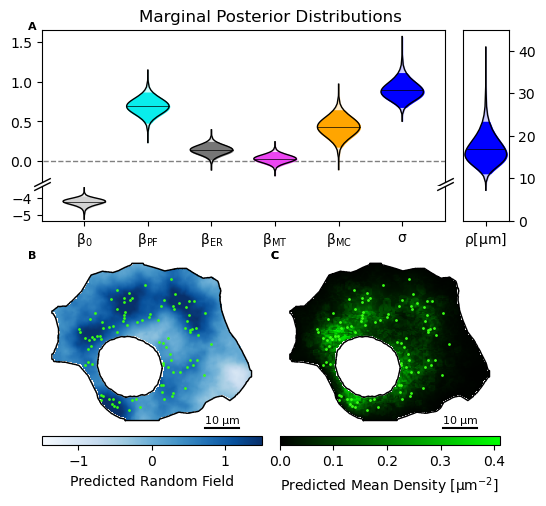

In [17]:
# now we add the marginals for the GRF

fig, main_ax = plt.subplots(figsize=(15/2.54,14/ 2.54))        

main_ax.axis('off')
marginals_ax = main_ax.inset_axes([0, 0.55,1, 0.45])


marginals_ax.axis('off')
marginals_ax.set_yticks([])
marginals_ax.set_xticks([])
marginals_ax.set_title("Marginal Posterior Distributions")

ax1 = marginals_ax.inset_axes([0, 0,0.88, 1])
ax1.axis('off')
ax1.set_yticks([])
ax1.set_xticks([])

top_pannel = ax1.inset_axes([0, 0.2,1, 0.8])

bot_pannel = ax1.inset_axes([0 , 0, 1, 0.18])


plot_marginal_violin_vertical(bot_pannel,  0,marginals["intercept"])

for i,key in enumerate([ 'proximity fraction','er','mitochondria', 'mitochondria proximity', 'standard deviation']):    
    plot_marginal_violin_vertical(top_pannel,  3*(i+1),marginals[key])


bot_pannel.set_xticks([0,3,6,9,12,15])
bot_pannel.set_xticklabels([r"$\mathrm{\beta_0}$",r"$\mathrm{\beta_{PF}}$",r"$\mathrm{\beta_{ER}}$",r"$\mathrm{\beta_{MT}}$",r"$\mathrm{\beta_{MC}}$",r"$\mathrm{\sigma}$"])
top_pannel.plot([-3,18],[0,0],color = "grey",linestyle = "--",linewidth = 1,zorder = -10)

top_pannel.set_xlim([-2,17])
bot_pannel.set_xlim([-2,17])

# hide the spines between ax and ax2
top_pannel.spines.bottom.set_visible(False)
bot_pannel.spines.top.set_visible(False)
top_pannel.set_xticks([])
#top_pannel.xaxis.tick_top()
top_pannel.tick_params(labeltop=False)  # don't put tick labels at the top
bot_pannel.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
top_pannel.plot([0, 1], [0, 0], transform=top_pannel.transAxes, **kwargs)
bot_pannel.plot([0, 1], [1, 1], transform=bot_pannel.transAxes, **kwargs)

ax2 = marginals_ax.inset_axes([0.92, 0,0.1, 1])
plot_marginal_violin_vertical(ax2, 0,marginals["range"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xticks([0])
ax2.set_xticklabels([r"$\mathrm{\rho[\mu m]}$"])
ax2.set_ylim([0,45])


from mpl_toolkits.axes_grid1 import make_axes_locatable

padding = 0.02

top_pad = 0.01
# First image and colorbar
grf_ax = main_ax.inset_axes([0, 0, 0.5 -padding, 0.5-top_pad])
im2 = grf_ax.imshow(random_field["mean"], cmap="Blues", extent=random_field["extent"],vmin=-1.5,vmax=1.5)

# Create a divider for grf_ax
divider = make_axes_locatable(grf_ax)
# Append a new axes for the colorbar
cax = divider.append_axes("bottom", size="5%", pad=-0)
# Add the colorbar to the new axes
cbar = plt.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label(r'Predicted Random Field')

# Additional plotting on grf_ax
grf_ax.plot([170 - 15, 170 - 5], [90, 90], color="black")
#grf_ax.text(s=r"$10\mathrm{\mu m}$", x=170 - 10, y=90, horizontalalignment="center")
grf_ax.scatter(
    pickled_data["cell3"]["point patterns"]["peroxisomes"][0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["point patterns"]["peroxisomes"][1] + 1000 / pickled_data["scale"],
    s=1, color="#39FF14"
)


grf_ax.plot(
    pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

grf_ax.plot(
    pickled_data["cell3"]["contours"]["cell"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["cell"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

grf_ax.fill( pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"], color='white') 



grf_ax.axis("off")

# Second image and colorbar
mean_density_ax = main_ax.inset_axes([0.5+ padding, 0, 0.5-padding, 0.5-top_pad])
black_to_green = LinearSegmentedColormap.from_list('BlackGreen',  [(0, 0, 0), (0, 1, 0)], N=256)
im = mean_density_ax.imshow(mean_density["mean"], cmap=black_to_green, extent=mean_density["extent"],vmin=0,vmax=0.41)

# Create a divider for mean_density_ax
divider = make_axes_locatable(mean_density_ax)
# Append a new axes for the colorbar
cax = divider.append_axes("bottom", size="5%", pad=-0)
# Add the colorbar to the new axes
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'Predicted Mean Density $\mathrm{[\mu m^{-2}]}$')

# Additional plotting on mean_density_ax
mean_density_ax.plot([170 - 15, 170 - 5], [90, 90], color="black")
#mean_density_ax.text(s=r"$10\mathrm{\mu m}$", x=170 - 10, y=90, horizontalalignment="center")
mean_density_ax.scatter(
    pickled_data["cell3"]["point patterns"]["peroxisomes"][0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["point patterns"]["peroxisomes"][1] + 1000 / pickled_data["scale"],
    s=1, color="#39FF14"
)

mean_density_ax.plot(
    pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

mean_density_ax.plot(
    pickled_data["cell3"]["contours"]["cell"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["cell"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

mean_density_ax.fill( pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"], color='white') 

mean_density_ax.axis("off")




plt.savefig("../figures/marginals_peroxisomes.pdf",bbox_inches='tight',dpi = 300, pad_inches=0)



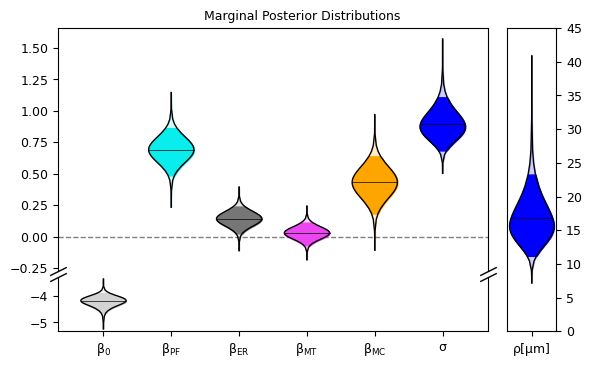

In [61]:
# now we add the marginals for the GRF

fig, main_ax = plt.subplots(figsize=(16/2.54,10/ 2.54))        

main_ax.axis('off')

marginals_ax = main_ax
marginals_ax.set_yticks([])
marginals_ax.set_xticks([])
marginals_ax.set_title("Marginal Posterior Distributions",size = 9)

ax1 = marginals_ax.inset_axes([0, 0,0.88, 1])
ax1.axis('off')
ax1.set_yticks([])
ax1.set_xticks([])

top_pannel = ax1.inset_axes([0, 0.2,1, 0.8])

bot_pannel = ax1.inset_axes([0 , 0, 1, 0.18])


plot_marginal_violin_vertical(bot_pannel,  0,marginals["intercept"])

for i,key in enumerate([ 'proximity fraction','er','mitochondria', 'mitochondria proximity', 'standard deviation']):    
    plot_marginal_violin_vertical(top_pannel,  3*(i+1),marginals[key])


bot_pannel.set_xticks([0,3,6,9,12,15])
bot_pannel.set_xticklabels([r"$\mathrm{\beta_0}$",r"$\mathrm{\beta_{PF}}$",r"$\mathrm{\beta_{ER}}$",r"$\mathrm{\beta_{MT}}$",r"$\mathrm{\beta_{MC}}$",r"$\mathrm{\sigma}$"])
top_pannel.plot([-3,18],[0,0],color = "grey",linestyle = "--",linewidth = 1,zorder = -10)

top_pannel.set_xlim([-2,17])
bot_pannel.set_xlim([-2,17])

# hide the spines between ax and ax2
top_pannel.spines.bottom.set_visible(False)
bot_pannel.spines.top.set_visible(False)
top_pannel.set_xticks([])
#top_pannel.xaxis.tick_top()
top_pannel.tick_params(labeltop=False)  # don't put tick labels at the top
bot_pannel.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
top_pannel.plot([0, 1], [0, 0], transform=top_pannel.transAxes, **kwargs)
bot_pannel.plot([0, 1], [1, 1], transform=bot_pannel.transAxes, **kwargs)

ax2 = marginals_ax.inset_axes([0.92, 0,0.1, 1])
plot_marginal_violin_vertical(ax2, 0,marginals["range"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xticks([0])
ax2.set_xticklabels([r"$\mathrm{\rho[\mu m]}$"])
ax2.set_ylim([0,45])






plt.savefig("../figures/marginals_peroxisomes.svg",bbox_inches='tight')


ax2.tick_params(axis='both', which='major', labelsize=9)
ax1.tick_params(axis='both', which='major', labelsize=9)

top_pannel.tick_params(axis='both', which='major', labelsize=9)
bot_pannel.tick_params(axis='both', which='major', labelsize=9)

plt.savefig("../figures/marginals_peroxisomes.svg",bbox_inches='tight', pad_inches=0)



## Analysis on simulated data 




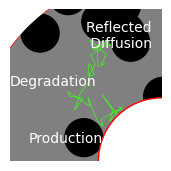

In [445]:

# Load the pickle data
import pickle
from simulation import Simulation,Point

import matplotlib as mlp
fig, model_ax =plt.subplots(figsize=((17 /3) /2.54,5/ 2.54)) 


# SETUP UP SETTINGS
CELL_RADIUS = 1
NUCLEUS_RADIUS = 1/3
CROWDER_RADIUS = 0.1
MEAN_DENSITY_OF_CROWDERS = 10
PRODUCTION_RATE = 100
DEGRADATION_RATE = 1
DIFFUSION_COEFFICIENT = 0.3
DT = 0.001

dummy_sim =  Simulation(CELL_RADIUS, 
                 NUCLEUS_RADIUS, 
                 CROWDER_RADIUS,
                 MEAN_DENSITY_OF_CROWDERS, 
                 PRODUCTION_RATE,
                 DEGRADATION_RATE,
                 DIFFUSION_COEFFICIENT,
                DT)


a_cell = dummy_sim.cell
a_nucleus = dummy_sim.nucleus


cell_circle = plt.Circle((a_cell.center.x,a_cell.center.y), a_cell.radius, edgecolor ="red", fc = "Grey")
model_ax.add_artist(cell_circle)

nucleus_circle = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius, edgecolor ="red",fc = "white",zorder = 10)
model_ax.add_artist(nucleus_circle)

annulus = mpl.patches.Annulus((a_cell.center.x,a_cell.center.y), 2*a_cell.radius,width = a_cell.radius, fc = "white",zorder = 10)
model_ax.add_artist(annulus)


for crowder in dummy_sim.crowders:
    crowder_circle = plt.Circle((crowder.center.x,crowder.center.y), crowder.radius, color ="black")
    model_ax.add_artist(crowder_circle)


dummy_sim.particles.append(Point(-NUCLEUS_RADIUS/np.sqrt(2), NUCLEUS_RADIUS/np.sqrt(2)))
coord_x, coord_y = dummy_sim.get_particle_coordinates()
trajectory_x = [dummy_sim.particles[0].x]
trajectory_y = [dummy_sim.particles[0].y]
for i in range(200):

    dummy_sim.diffuse_particles()
    if i % 5 ==0:
        trajectory_x.append(dummy_sim.particles[0].x)
        trajectory_y.append(dummy_sim.particles[0].y)

model_ax.plot(trajectory_x,trajectory_y,color = "#39FF14",linewidth =0.5)
model_ax.set_xlim([-0.8*a_cell.radius, 0 ])
model_ax.set_ylim([0,0.8*a_cell.radius])

model_ax.set_aspect('equal', adjustable='box')
model_ax.text(-0.4,0.6,f"Reflected \n Diffusion",color = "white",size = 10)
model_ax.text(-0.7,0.1,"Production",color = "white",zorder = 100,size = 10)
model_ax.text(-0.8,0.4,"Degradation",color = "white",zorder = 100,size = 10)

model_ax.axis("off")
plt.show()


In [447]:
fig.savefig("../figures/simulated_data/model.svg",bbox_inches='tight')


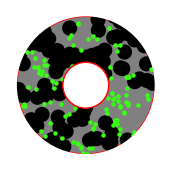

In [9]:

# Load the pickle data
import pickle
from simulation import Simulation
import matplotlib as mpl

with open("../data/synthetic_data/diffusion_in_crowded_enviroment/synthetic_data.pkl", 'rb') as file:
    simulations = pickle.load(file)

a_cell = simulations[0].cell
a_nucleus = simulations[0].nucleus

fig, realization_ax =plt.subplots(figsize=((17 /3) /2.54,5/ 2.54)) 

cell_circle = plt.Circle((a_cell.center.x,a_cell.center.y), a_cell.radius, edgecolor ="red", fc = "Grey")
realization_ax.add_artist(cell_circle)

nucleus_circle = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius, edgecolor ="red",fc = "white",zorder = 10)
realization_ax.add_artist(nucleus_circle)

annulus = mpl.patches.Annulus((a_cell.center.x,a_cell.center.y), 2*a_cell.radius,width = a_cell.radius, fc = "white",zorder = 10)
realization_ax.add_artist(annulus)


for crowder in simulations[3].crowders:
    crowder_circle = plt.Circle((crowder.center.x,crowder.center.y), crowder.radius, color ="black")
    realization_ax.add_artist(crowder_circle)

coord_x, coord_y = simulations[3].get_particle_coordinates()
realization_ax.scatter(coord_x,coord_y,color = "#39FF14",s = 5)
realization_ax.set_xlim([-1.1*a_cell.radius,1.1*a_cell.radius])
realization_ax.set_ylim([-1.1*a_cell.radius,1.1*a_cell.radius])

realization_ax.set_aspect('equal', adjustable='box')

realization_ax.axis("off")

#fig.savefig("../figures/simulated_data/realization.svg",bbox_inches='tight')

plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


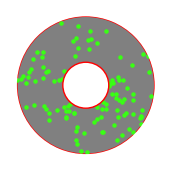

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

with open("../data/synthetic_data/diffusion_in_crowded_enviroment/synthetic_data.pkl", 'rb') as file:
    simulations = pickle.load(file)

a_cell = simulations[0].cell
a_nucleus = simulations[0].nucleus

fig, realization_ax =plt.subplots(figsize=((17 /3) /2.54,5/ 2.54)) 

cell_circle = plt.Circle((a_cell.center.x,a_cell.center.y), a_cell.radius, edgecolor ="red", fc = "Grey")
realization_ax.add_artist(cell_circle)

nucleus_circle = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius, edgecolor ="red",fc = "white",zorder = 10)
realization_ax.add_artist(nucleus_circle)

annulus = mpl.patches.Annulus((a_cell.center.x,a_cell.center.y), 2*a_cell.radius,width = a_cell.radius, fc = "white",zorder = 10)
realization_ax.add_artist(annulus)


#for crowder in simulations[3].crowders:
#    crowder_circle = plt.Circle((crowder.center.x,crowder.center.y), crowder.radius, color ="black")
#    realization_ax.add_artist(crowder_circle)

coord_x, coord_y = simulations[3].get_particle_coordinates()
scatter_plot = realization_ax.scatter(coord_x,coord_y,color = "#39FF14",s = 5)
realization_ax.set_xlim([-1.1*a_cell.radius,1.1*a_cell.radius])
realization_ax.set_ylim([-1.1*a_cell.radius,1.1*a_cell.radius])

realization_ax.set_aspect('equal', adjustable='box')

realization_ax.axis("off")


def update(frame):
    # 'frame' is the current frame index. We can use it to shift the wave.
    
    # Shift the sine wave by a certain amount each frame to create an animation.
    # For example, let's move the wave to the left over time.

    simulations[3].simulate(1)
    coord_x, coord_y = simulations[3].get_particle_coordinates()


    scatter_plot.set_offsets(np.column_stack((coord_x, coord_y)))
    return scatter_plot,



ani = FuncAnimation(fig, update, frames=200, interval=30, blit=True, repeat=False)

ani.save('animation_wo_crowders.gif', writer='imagemagick')

plt.show()

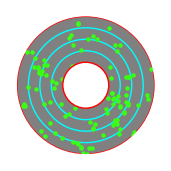

In [11]:

# Load the pickle data
import matplotlib as mpl
import pickle
from simulation import Simulation

with open("../data/synthetic_data/diffusion_in_crowded_enviroment/synthetic_data.pkl", 'rb') as file:
    simulations = pickle.load(file)

a_cell = simulations[0].cell
a_nucleus = simulations[0].nucleus

fig, data_ax =plt.subplots(figsize=((17 /3) /2.54,5/ 2.54)) 

cell_circle = plt.Circle((a_cell.center.x,a_cell.center.y), a_cell.radius, edgecolor ="red", fc = "Grey")
data_ax.add_artist(cell_circle)

nucleus_circle = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius, edgecolor ="red",fc = "white",zorder = 10)
data_ax.add_artist(nucleus_circle)


nucleus_circle_1 = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius + 0.25*(2/3), edgecolor ="cyan",fill = False)
data_ax.add_artist(nucleus_circle_1)

nucleus_circle_2 = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius +  0.5*(2/3), edgecolor ="cyan",fill = False)
data_ax.add_artist(nucleus_circle_2)

nucleus_circle_3 = plt.Circle((a_nucleus.center.x,a_nucleus.center.y), a_nucleus.radius +  0.75*(2/3), edgecolor ="cyan",fill = False)
data_ax.add_artist(nucleus_circle_3)

annulus = mpl.patches.Annulus((a_cell.center.x,a_cell.center.y), 2*a_cell.radius,width = a_cell.radius, fc = "white",zorder = 10)
data_ax.add_artist(annulus)

coord_x, coord_y = simulations[3].get_particle_coordinates()


data_ax.scatter(coord_x,coord_y,color = "#39FF14",s = 5)
data_ax.set_xlim([-1.1*a_cell.radius,1.1*a_cell.radius])
data_ax.set_ylim([-1.1*a_cell.radius,1.1*a_cell.radius])

data_ax.set_aspect('equal', adjustable='box')

data_ax.axis("off")

fig.savefig("../figures/simulated_data/data.svg",bbox_inches='tight')



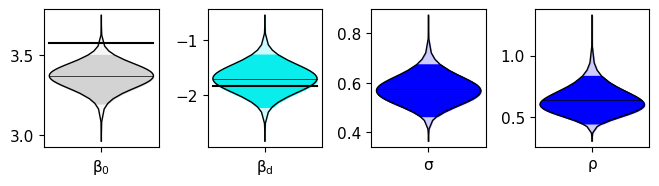

In [59]:
def plot_marginal_violin_vertical(ax,shift,marginal):

    color = marginal["color"]
    posterior = np.array(marginal["pdf"])
    x = posterior[:,0]
    y = posterior[:,1]/np.max(posterior[:,1])

    ax.plot( y+shift, x,color = "black",linewidth = 1)
    ax.plot( shift-y,x,color = "black",linewidth = 1)

    ax.fill_betweenx(x, shift-y,shift+y, color= color, alpha=0.2,interpolate=True)

    summary = marginal["summary"][0]

    
    x_conf = x[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    y_conf = y[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    ax.fill_betweenx(x_conf, shift-y_conf,shift+y_conf, color=color, alpha=1,interpolate=True)

    ax.plot([shift - y[np.searchsorted(x, summary['mean'])],y[np.searchsorted(x, summary['mean'])]+shift],[summary['mean'],summary['mean']],color = "black",linewidth = 0.5)


fig, marginal_axes =plt.subplots( nrows=1, ncols=4  ,figsize=((17) /2.54,5/ 2.54)) 


x_pad = 0.08


# Path to the combined JSON file
path_to_data = '../data/synthetic_data/diffusion_in_crowded_enviroment/'  # Replace with your actual file path

# Load JSON data
with open(path_to_data + 'marginals.json', 'r') as f:
    marginals = json.load(f)

marginals["intercept"]["color"] =  "lightgrey"
marginals["distance"]["color"] = "#09edecff"
marginals["range"]["color"] =  "blue"
marginals["standard deviation"]["color"] = "blue"


pad_x = 0.1

marginal_axes[0].plot([-1,1], [np.log(expected_mean_density),np.log(expected_mean_density)],color = "black")
                    
plot_marginal_violin_vertical(marginal_axes[0], 0 ,marginals["intercept"])

plot_marginal_violin_vertical(marginal_axes[1], 0 ,marginals["distance"])
marginal_axes[1].plot([-1,1], [-lmd,-lmd],color = "black")

plot_marginal_violin_vertical(marginal_axes[2], 0 ,marginals["standard deviation"])

plot_marginal_violin_vertical(marginal_axes[3], 0 ,marginals["range"])

marginal_axes[0].set_xticks([0])
marginal_axes[0].set_yticks([3,3.5])

marginal_axes[0].set_xticklabels([r"$\mathrm{\beta_0}$"])



marginal_axes[1].set_xticks([0])
marginal_axes[1].set_xticklabels([r"$\mathrm{\beta_d}$"])

marginal_axes[2].set_xticks([0])
marginal_axes[2].set_xticklabels([r"$\mathrm{\sigma}$"])

marginal_axes[3].set_xticks([0])
marginal_axes[3].set_xticklabels([r"$\mathrm{\rho}$"])


marginal_axes[0].tick_params(axis='both', which='major', labelsize=11)
marginal_axes[1].tick_params(axis='both', which='major', labelsize=11)
marginal_axes[2].tick_params(axis='both', which='major', labelsize=11)
marginal_axes[3].tick_params(axis='both', which='major', labelsize=11)

fig.tight_layout() 



fig.savefig("../figures/simulated_data/marginals.svg",bbox_inches='tight')
